# Final ML Project
## Daniel Bernal, Raymond Vuong, Rohit Punjani, and Neal Davar 


In [3]:
# import statements

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
# Constants and other global variables: 

IL_F_ITERATIONS = 50

In [71]:
# clean data by dropping cols like Id, imputing value
# depending on the feature, and dropping duplicates:
def clean_data(dataset, is_training): 
    dataset.drop('Id', axis=1, inplace=True)

    if is_training: 
        dataset.drop('SalePrice', axis=1, inplace=True)

        # for i in range(0, len(cols_to_chnage)):
        #     dataset[i] = dataset[i].astype(int)
                     
    # print(training.shape)
    # training.head()
    null_counts = dataset.isnull().sum()
    missing_features = null_counts[null_counts > 0]
    print(missing_features)
    
    
    # grab all the numeric features and plot histograms
    numeric_feats = dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    # TODO: UNCOMMENT THIS BEFORE SUBMISSION!
    # for i in numeric_feats.columns:
    #     plt.hist(numeric_feats[i])
    #     plt.title(i)
    #     plt.show()
        
    # fillna on the basis of whether MasVnrArea, LotFrontage, or any other categorical feature with na values
    # dataset['MasVnrArea'].fillna(0, inplace=True)
    # dataset['LotFrontage'].fillna(0, inplace=True)
    dataset['GarageYrBlt'].fillna(dataset['GarageYrBlt'].mean(), inplace=True)
    print('before: ')
    before_var = [col for col, dt in dataset.dtypes.items() if dt == object]
    numeric_columns = dataset.select_dtypes(include=['number']).columns 
    print(numeric_columns)
    dataset[numeric_columns] = dataset[numeric_columns].fillna(0, inplace=True)

    print('numeric nulls: ')
    print(dataset[numeric_columns].sum())

    dataset.fillna('None', inplace=True)
    print('after: ')
    after_var = [col for col, dt in dataset.dtypes.items() if dt == object]
    print(before_var)
    print(after_var)
    print(len(after_var) - len(before_var))
    

    # drop duplicates:
    dataset.drop_duplicates(keep=False, inplace=True)

    # plot correlation between features: 
    corr_mat = dataset.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corr_mat, square=True)

    # Changing categorial features to be stored as string
    dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)

    # one hot encode:
    ohe_col_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']   
    
    print('shape pre OHE: ', dataset.shape)
    
    dataset_dropped = pd.get_dummies(
        data=dataset, columns=ohe_col_list, drop_first=True)
    

    print('shape post OHE: ', dataset_dropped.shape)


    return dataset_dropped

In [16]:
# TODO: ASK ANSHUL!!
def one_hot_encoder(training, testing):
   
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first')
    labels = training['SalePrice']
    training_features = training.drop('SalePrice', axis=1)
    ohe.fit(training_features)
    transform_training = pd.DataFrame(ohe.transform(training_features).toarray())
    print(ohe.get_feature_names_out())
    transform_testing = pd.DataFrame(ohe.transform(testing).toarray())

    pd.concat([transform_training, labels], axis=1)

    print(transform_training)
    print(transform_testing)

    return transform_training, transform_testing


In [4]:
# Uses the isolation forest technique to find outliers across 50 iterations
# and removes records that are recorded as outliers > 10% of the time
def run_isolation_forest(training):
    # use isolation forests to find potential outliers:
    freq_outlier_map = {} 
    for i in range(0, IL_F_ITERATIONS):
        anomalies = IsolationForest().fit_predict(training, 0.5)
        training['anomalies'] = anomalies
        outlier_indices = training.loc[training['anomalies'] == -1].index
        # add outlier freqs to map
        for j in range(0, len(outlier_indices)):
            count = 0
            if outlier_indices[j] in freq_outlier_map: 
                count = freq_outlier_map[outlier_indices[j]]
            freq_outlier_map[outlier_indices[j]] = count + 1
        
        inlier_indices = training.loc[training['anomalies'] == 1].index
        

        
    # drop outliers that are detected as anomalies more than 10% of the time
    final_outlier_indices = []
    print('Total # of Outliers: ')
    for outlier_index in freq_outlier_map.keys(): 
        if freq_outlier_map[outlier_index] > (0.10 * IL_F_ITERATIONS):
            final_outlier_indices.append(outlier_index)
    print(len(final_outlier_indices))
    print('Number of data points before outlier removal: ')
    print(len(training))
    training.drop(index=final_outlier_indices, inplace=True)
    print('Number of data points before after outlier removal: ')
    print(len(training))


In [24]:
# function that normalizes the training and testing data:
def normalize_data(train, test):
    # your code goes here
    train_norm = (train - train.min()) / (train.max() - train.min())
    test_norm = (test - test.min()) / (test.max() - test.min())
    return train_norm, test_norm

In [6]:
# feature engineering of consolidating bathroom
def fe_bathrooms(dataset):
    # consolidate bathroom columns into one col:
    dataset['TotalBathrooms'] = \
        dataset['FullBath'] + (0.5 * dataset['HalfBath']) + \
        dataset['BsmtFullBath'] + (0.5 * dataset['BsmtHalfBath'])
    dataset.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

In [ ]:
# feature engineering of consolidating porch sq ft: 
def fe_porch(dataset):
    # consolidate porch area into one column
    dataset['TotalPorchSF'] = dataset['OpenPorchSF'] + \
        dataset['EnclosedPorch'] + \
        dataset['3SsnPorch'] + dataset['ScreenPorch']

    dataset.drop(['OpenPorchSF', 'EnclosedPorch',
                  '3SsnPorch', '3SsnPorch'], axis=1)


In [7]:
# Run Decision Tree Regression on our Data: 
def do_decision_tree_regression(training):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis=1)
  x_train, x_test, y_train, y_test = train_test_split(
      features, labels, test_size=0.20)
  dt = DecisionTreeRegressor(random_state=2)
  dt.fit(x_train, y_train)
  # Prediction = np.zeros((len(y_test), 1))
  Prediction = dt.predict(x_test)
  print("R2 Score No Crossval")
  print(metrics.r2_score(y_test, Prediction))
  print("MSE")
  print(metrics.mean_squared_error(y_test, Prediction))

  #outerloop of crossval
  cv = cross_val_score(dt, features, labels, cv=10)
  r2 = sum(cv) / cv.size
  # print(r2)
  #innerloop of crossval
  parameters = {'max_depth': [5, 10, 15, 20, 30, 40], 'min_samples_leaf': [
      5, 10, 15, 20, 30, 40], 'max_features': [5, 10, 15, 30, 40]}
  grid = GridSearchCV(DecisionTreeRegressor(),
                      param_grid=parameters, cv=10, scoring='r2')
  grid.fit(features, labels)
  print("Best parameters")
  print(grid.best_params_)
  # print(grid.best_score_)

  #combined
  cv = cross_val_score(grid, features, labels, cv=5)
  r2 = sum(cv)/cv.size
  print("R2 with cross val")
  print(r2)

In [8]:
# KNN Regression Model Implementation: 
#KNN regression
def do_KNN_regression(training):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis=1)
  x_train, x_test, y_train, y_test = train_test_split(
      features, labels, test_size=0.20)
  dt = KNeighborsRegressor()
  dt.fit(x_train, y_train)
  # Prediction = np.zeros((len(y_test), 1))
  Prediction = dt.predict(x_test)
  print("R2 Score No Crossval")
  print(metrics.r2_score(y_test, Prediction))
  print("MSE")
  print(metrics.mean_squared_error(y_test, Prediction))

  #outerloop of crossval
  cv = cross_val_score(dt, features, labels, cv=10)
  r2 = sum(cv) / cv.size
  # print(r2)
  #innerloop of crossval
  parameters = {'n_neighbors': [5, 10, 15, 20, 30, 40]}
  grid = GridSearchCV(KNeighborsRegressor(),
                      param_grid=parameters, cv=10, scoring='r2')
  grid.fit(features, labels)
  print("Best parameters")
  print(grid.best_params_)
  # print(grid.best_score_)

  #combined
  cv = cross_val_score(grid, features, labels, cv=5)
  r2 = sum(cv)/cv.size
  print("R2 with cross val")
  print(r2)


In [9]:
# run a linear regression model 
def runLinReg(train_norm):
    labels = train_norm['SalePrice']
    labels.values.ravel()
    features = train_norm.drop('SalePrice', axis=1)
    print(features.shape)
    print(labels.shape)
    print(features.head())
    print(labels.head())


    linReg = LinearRegression()
    scores = cross_val_score(linReg, features, labels, cv=10)
    print("Accuracy:", scores.mean()*100)


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
before: 
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


/var/folders/wg/fd60dmln4nq615ms_jvbcyj40000gn/T/ipykernel_30292/1516434755.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[numeric_columns] = dataset[numeric_columns].fillna(0, inplace=True)


ValueError: zero-size array to reduction operation fmin which has no identity

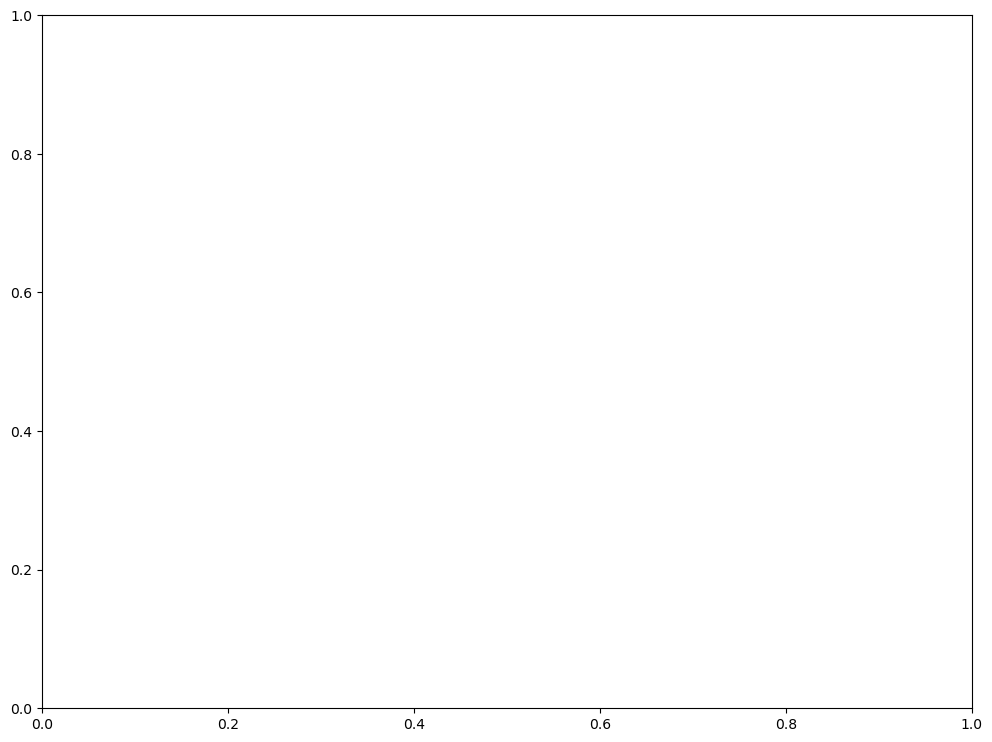

In [72]:

training = pd.read_csv("train.csv")
testing = pd.read_csv("housing_testing.csv")
pd.options.display.max_rows = 10_000




# 1. Data Cleaning
training = clean_data(training, True)
testing = clean_data(testing, False)

#  do an inner join to make sure we have the same shape in test and train
final_train, final_test = training.align(testing, join='inner', axis=1)
# print(final_train.dtypes == final_test.dtypes)
# print(type(final_train['BsmtFinSF1'][0]))
# print(type(final_test['BsmtFinSF1'][0]))


# print(type(final_train['BsmtFullBath'][0]))
# print(type(final_test['BsmtHalfBath'][0]))

# print(type(final_train['GarageArea'][0]))
# print(type(final_test['GarageArea'][0]))

# print([col for col, dt in final_train.dtypes.items() if dt == object])
# print([col for col, dt in final_test.dtypes.items() if dt == object])









# one_hot_encoder(training, testing)

#2. Data Cleaning Pt. 2
# run_isolation_forest(training)
# print(training.dtypes)
# print(testing.dtypes)
# 2. Normalization
train_norm, test_norm = normalize_data(final_train, final_test)




# numerics =  ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# testing_select = testing.select_dtypes(exclude=numerics)


# training_select = training.select_dtypes(exclude=numerics)

# print(testing_select.shape)
# print(training_select.shape)

# print(training.head)
# print(testing.head)



# #3. Data Exploration: 




